# 가장 좋은 결과를 낼 수 있는 feature항목 추출

## 모든 feature를 사용한 결과와, 선택 추출된 feature만 사용한 결과 정확도에 차이가 남
#### logistic 회귀 이용하여 coef_ 항목에서 영향력이 높은 feature를 선택. 최적의 갯수 선택

### 데이터 준비하기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# 로지스틱회귀후에 .coef_ 항목에서 기준(criteria, 계수)보다 높은 영향력을 미치는 feature column 선택
def select_features(df, coef, criteria):
    sel_num = np.where(np.abs(coef) > criteria )[1]
    sel_col = df.columns[sel_num]
    return sel_col

In [3]:
def get_scores(data, target):
    train_input, test_input, train_target, test_target = train_test_split(data, target, random_state=42, test_size=0.2, stratify=target)

    ss = StandardScaler()
    ss.fit(train_input)
    train_scaled = ss.transform(train_input)
    test_scaled = ss.transform(test_input)

    lr = LogisticRegression(C=20, max_iter=4000) # max_iter default 100, 
#     lr = LogisticRegression(C=1, solver='newton_cg', max_iter=1000) # max_iter default 100, 
    lr.fit(train_scaled, train_target)

    train_score = lr.score(train_scaled, train_target)
    test_score = lr.score(test_scaled, test_target)
#     print(f'train score: {train_score:.4f} \n test score; {test_score:.4f}')
    return train_score, test_score, lr.coef_, lr.intercept_

In [4]:
def find_best_result(data, target):
# min을 하나씩 제거하면서 최고의 결과를 가져오는 feature갯수(항목) 선택

    train_score_list= []
    test_score_list = []
#     data_columns = []
#     data_coef = []
    test_s = 0
    train_score, test_score, coef, intercept = get_scores(data, target)
    for _ in range(len(data.columns)-1):
        criteria = np.abs(coef).min()
        sel_col = select_features(data, coef, criteria)
        data = df[sel_col]
        train_score, test_score, coef, intercept = get_scores(data, target)

        if test_score > test_s:
            test_s = test_score
            data_columns = sel_col
            data_coef = coef

        train_score_list.append(train_score)
        test_score_list.append(test_score)
    
    return train_score_list, test_score_list, data_columns, data_coef

In [139]:
# 분석용 데이터 입력
directory_for_ml = '../data/data_for_ml/'
fname = 'df_naver_sel.pkl'
f_name = directory_for_ml + fname
df = pd.read_pickle(f_name)
plt_title = fname[3:7]

In [140]:
data = df.iloc[:, :-3]

# target = df.iloc[:, -1]
# plt_title2 = 'r_open_high'

target = df.iloc[:, -2]
plt_title2 = 'close_cr'

In [141]:
train_score_list, test_score_list, data_columns, data_coef = find_best_result(data, target)

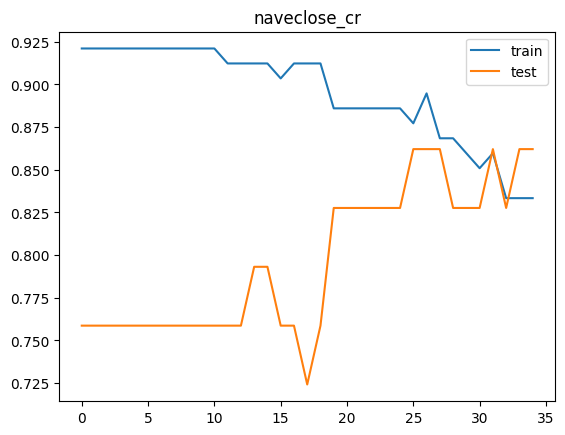

In [142]:
plt.plot(train_score_list, label = 'train')
plt.plot(test_score_list, label = 'test')
plt.title(plt_title+plt_title2)
plt.legend()

In [143]:
print(data_columns, data_coef)
print("train_max: {:.4f}, test_max: {:.4f}".format(max(train_score_list), max(test_score_list)))

Index(['foreigner', 'pension', 'dji_cr', 'dji_f_cr', 'ixic_cr', 'spx_cr',
       'bond_kor_10_cr', 'bond_kor_2_cr', 'bond_usa_10_cr', 'kospi_cr'],
      dtype='object') [[-1.14521719 -1.54415468 -4.31313927  3.0339479   2.70047416 -1.41365288
  -0.72597195  0.70146031 -0.3548567   3.07480143]]
train_max: 0.9211, test_max: 0.8621


In [144]:
data_columns.shape

(10,)

In [145]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate, train_test_split
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

In [146]:
data_new = data[data_columns]
# target = df.iloc[:, -2]  # logistic regression에서 생성된 target을 그대로 사용

In [147]:
data_new.tail()

,foreigner,pension,dji_cr,dji_f_cr,ixic_cr,spx_cr,bond_kor_10_cr,bond_kor_2_cr,bond_usa_10_cr,kospi_cr
2023-02-13,-1.173188,-2.027792,1.11,1.10,1.48,1.14,2.32,2.02,-1.02,-0.69
2023-02-14,-4.321329,0.951427,-0.46,-0.43,0.57,-0.03,-1.02,-0.37,1.34,0.53
2023-02-15,-0.610591,-1.179369,0.11,0.16,0.92,0.28,1.88,1.82,1.33,-1.53
2023-02-16,-0.325102,7.349070,-1.27,-1.27,-1.78,-1.38,0.40,0.33,1.58,1.96
2023-02-21,-1.148746,-3.600743,-2.06,-1.80,-2.50,-2.00,-0.30,-0.64,2.68,0.16


In [148]:
train_input, test_input, train_target, test_target = train_test_split(data_new, target, random_state=42, test_size=0.2, stratify=target)

In [149]:
print(train_input.shape, train_target.shape)

(114, 10) (114,)


In [150]:
np.unique(train_target, return_counts=True)

(array([0, 1], dtype=int64), array([64, 50], dtype=int64))

In [151]:
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [152]:
value = []
for iter in range(5, 50, 1):
    sc = SGDClassifier(loss='log', max_iter=iter, random_state=42)
#     sc = SGDClassifier(max_iter=iter, random_state=42)
    scores = cross_validate(sc,
                            X=train_scaled, y=train_target,
                            n_jobs=-1)
#     print(scores['test_score'].mean())
    value.append(scores['test_score'].mean())

In [153]:
print("max", max(value))

max 0.8687747035573123


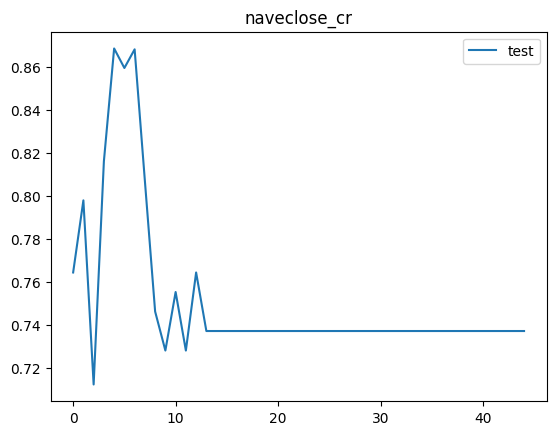

In [154]:
plt.plot(value, label = 'test')
plt.title(plt_title+plt_title2)
plt.legend()

### 인공신경망

In [155]:
def model_fn(inp_num, a_layer=None):
    model = Sequential()
    model.add(Dense(12, activation='sigmoid', input_shape=(inp_num,)))
#     model.add(Dropout(0.1))
    model.add(Dense(6, activation='sigmoid'))
#     model.add(Dropout(0.1))
    if a_layer:
        model.add(a_layer)
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [156]:
# model = model_fn(10, len(data_new.columns), 2, Dropout(0.3))
try :
    del model
    print("delete del")
except:
    pass
model = model_fn(len(data_new.columns))
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

delete del
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 12)                132       
                                                                 
 dense_19 (Dense)            (None, 6)                 78        
                                                                 
 dense_20 (Dense)            (None, 1)                 7         
                                                                 
Total params: 217
Trainable params: 217
Non-trainable params: 0
_________________________________________________________________


In [157]:
# checkpoint_cb = ModelCheckpoint('best_model.h5', save_best_only=True)
# checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath='best_model_{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}.h5', \
#                                                 monitor='val_accuracy', mode='max', save_best_only=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath='best_model.h5', save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=100, monitor='val_accuracy', mode='max', restore_best_weights=True)

In [158]:
np.unique(train_target), np.unique(test_target)

(array([0, 1], dtype=int64), array([0, 1], dtype=int64))

In [159]:
history = model.fit(train_scaled, train_target, epochs=2000, verbose=0,
                    callbacks=[checkpoint_cb, earlystopping_cb],
                    validation_data=(test_scaled, test_target))
# batch_size=

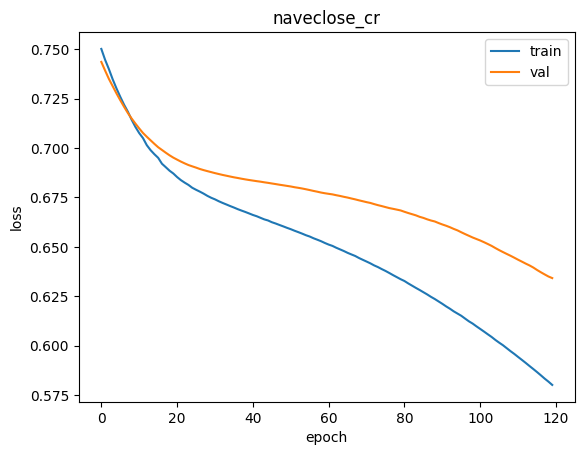

In [160]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.title(plt_title+plt_title2)
plt.show()

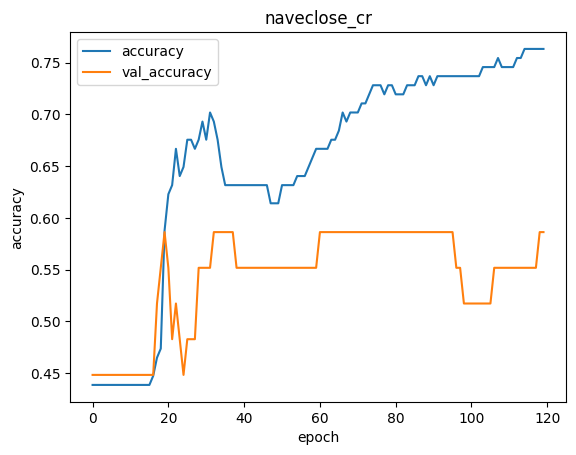

In [161]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.title(plt_title+plt_title2)
plt.show()

In [162]:
earlystopping_cb.stopped_epoch

119

In [163]:
model.evaluate(test_scaled, test_target)

1/1 [==============================] - 0s 13ms/step - loss: 0.6951 - accuracy: 0.5862


[0.6951097249984741, 0.5862069129943848]

In [164]:
model_val = load_model('best_model.h5')
model_val.evaluate(test_scaled, test_target)

1/1 [==============================] - 0s 63ms/step - loss: 0.6342 - accuracy: 0.5862


[0.634165346622467, 0.5862069129943848]

In [165]:
y_predict = model.predict(np.array(test_scaled))

1/1 [==============================] - 0s 33ms/step


In [166]:
y_predict_list = [1 if i > 0.5 else 0 for i in y_predict[:, 0]]

In [167]:
from sklearn.metrics import precision_score, recall_score
# 정밀도
precision_score(test_target, y_predict_list)  # 정밀도, 입력값의 순서 중요힘. (실제값, 예측값)

0.5263157894736842

In [168]:
# 재현율
recall_score(test_target, y_predict_list)  # 재현율, 입력값의 순서 중요힘. (실제값, 예측값)

0.7692307692307693

In [169]:
from sklearn.metrics import f1_score

f1_score(test_target, y_predict_list)

0.625

In [170]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_target, y_predict_list)

array([[ 7,  9],
       [ 3, 10]], dtype=int64)

In [138]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test_target, y_predict_list)

0.5

In [70]:
for innum in range(30):
    aa = np.array([test_scaled[innum]])
    y_predict = model.predict(aa)
#     print("predict: {},  target_value: {}".format(y_predict, test_target[innum]))

1/1 [==============================] - 0s 12ms/step


In [ ]:
### ROC 확인해 봐야 함. 정확도, 정밀도 등

In [ ]:
'''
model.save('my_model.h5')
model_new = load_model('my_model.h5')
model_new.evaluate(test_scaled, test_target)
'''